# FFT Signal Seeking with Windowing

We have seen that multiple short Fourier Transforms (SFTs) offer some advantages for seeking signals buried in long sequences of noisy if we can make a good guess about the nature of the signal. However, the simple algorithm has extremely uneven performance, reaching the power of a single FT of the whole sequence for signals that lie on the bin edges of the SFTs but failing more and more spectacularly as the signal frequency gets further from the bin edges until it offers no signal recovery at the center of an SFT frequency bin.

I believe that the underlying reason for this is the nature of the discrete Fourier Transform, which, despite its name, is actually much more closely related to the Fourier Series than to the transform. Since it uses a discrete set of sinusoids as its basis, it shares with the Fourier Series the restriction to periodic signals. Thus, when fed a finite-length signal, the algorithm acts as though the actual signal were an infinitely long string of repeated copies of the finite signal.

So long as the signal frequency falls on one of the basis frequencies (the bin edge frequencies) this causes no problem. The signal automatically contains an integral number of periods and the periodic reconstruction introduces no artefacts. Look at a simple example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's do 1 second of 10 ksps with a frequency of 21 Hz.

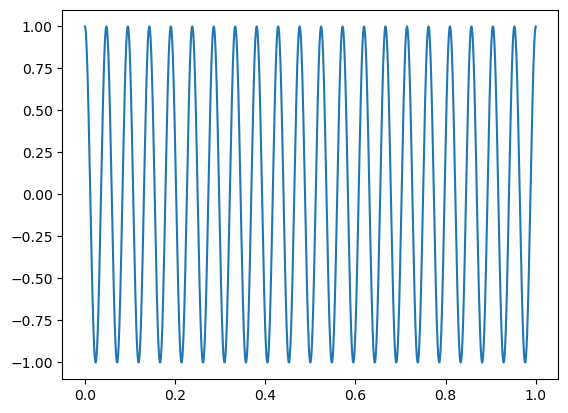

In [4]:
rate = 10_000
duration = 1.0
nSample = int(rate * duration)
time = np.linspace(0.0, duration, num=nSample, endpoint=False)
freq0 = 21
w0 = 2 * np.pi * freq0
sig = np.cos(w0 * time)
plt.plot(time, sig)

and it is quite clear that if you appended a second copy then you would have a nice continuous wave and could repeat this process ad inifinitum.

Thus, when we look at the full FT we get all our energy in a single bin.

In [5]:
fullFT = np.fft.rfft(sig)

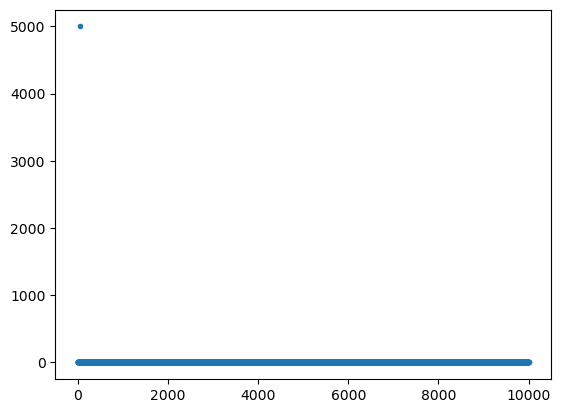

In [7]:
nFreq = int(nSample/2)+1
fullFreq = np.linspace(0, 1/(time[1]-time[0]), num=nFreq)
plt.plot(fullFreq, np.absolute(fullFT), '.')

and, as expected, all the energy is in a single bin.

Now, if we split the data into 10 SFTs and look at the signal in one of the frames we get

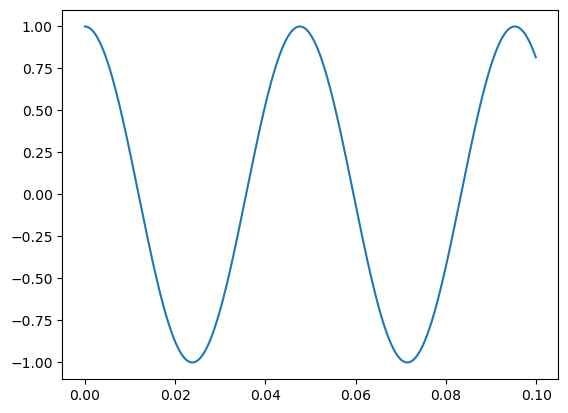

In [9]:
nFFT = 10
nPtPerSample = int(nSample/nFFT)
frames = np.reshape(sig, (nFFT, nPtPerSample),
                                 order='A')
plt.plot(time[:nPtPerSample], frames[0,:])

Oh dear! Now we see the problem. Here is what we get if we put three copies of this together.

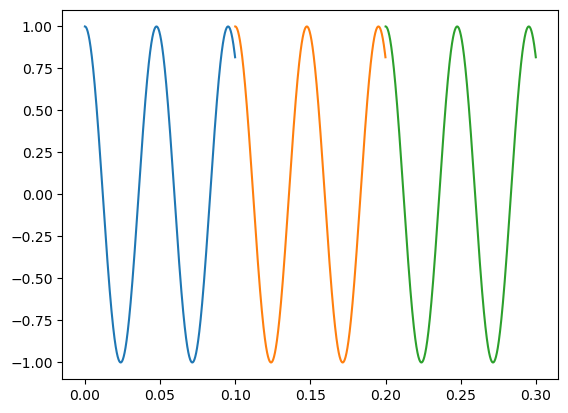

In [10]:
plt.plot(time[:nPtPerSample], frames[0,:],time[:nPtPerSample]+0.1, frames[0,:],time[:nPtPerSample]+0.2, frames[0,:])

Our 'periodic' signal now has nasty breaks instead of being a smooth curve. We can see the effect on the Fourier transform (note that I have blown up the lower frequency portion to make the effect more visible).

In [21]:
nSFreq = int(nPtPerSample/2)+1
shortFreq = np.linspace(0, 1/(time[1]-time[0]), num=nSFreq)
SFT = np.fft.rfft(frames[0, :])

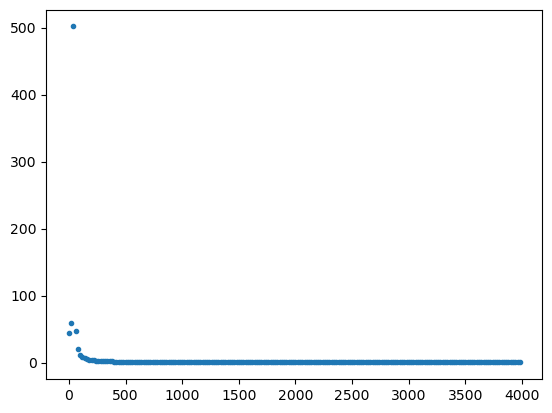

In [22]:
plt.plot(shortFreq[:200], np.absolute(SFT[:200]), '.')

So now the energy, instead of being confined to a single bin, is spread over a small range of bins centered on the closest frequency (20 Hz). This is not too bad in one bin but, as we have seen, the details of the spread varies from SFT to SFT so that it takes great care to reconstruct the original signal.

## Windowing

It would seem that there might be a way to make this problem better. The traditional solution is called "windowing". Essentially, we fade the edges of the signal to zero so that we don't get the nasty sharp edges that we saw in the concatentated figure above.

Python provides a number of classic window functions. I am going to look at the Hamming window, which was created by one of the people involved in the original discrete fourier transform research. Here is the Hamming window for our SFT.

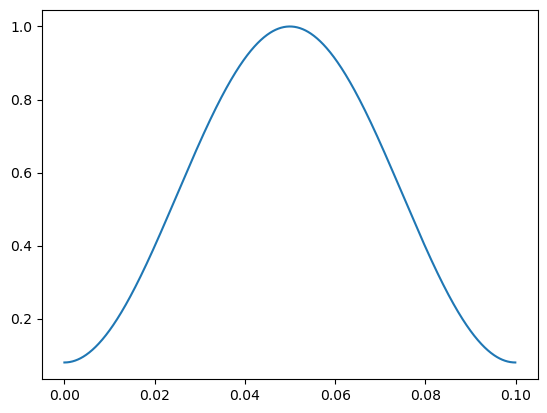

In [16]:
wind = np.hamming(nPtPerSample)
plt.plot(time[:nPtPerSample], wind)

and here is what we get when we multiply our function by the window function.

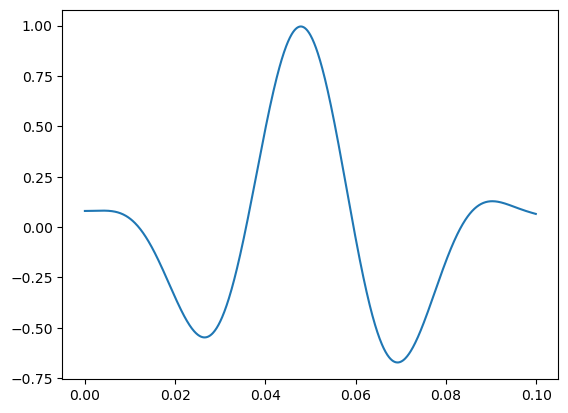

In [17]:
wframe = frames[0, :] * wind
plt.plot(time[:nPtPerSample], wframe)

Because the signal now goes nearly to zero at the edges, the discontinuities for the repeated version are small.

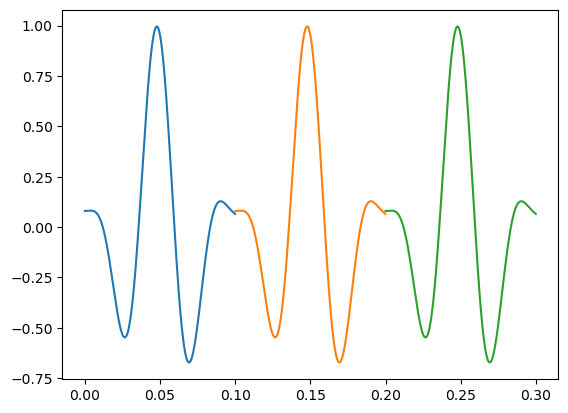

In [18]:
plt.plot(time[:nPtPerSample], wframe)
plt.plot(time[:nPtPerSample]+0.1, wframe)
plt.plot(time[:nPtPerSample]+0.2, wframe)

and the resulting Fourier transform looks like this (again, zoomed in on the low frequencies).

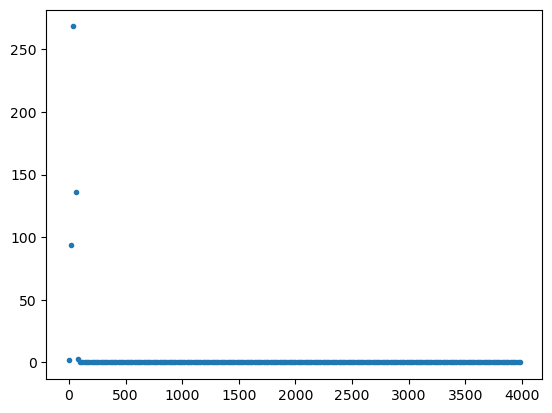

In [20]:
wSFT = np.fft.rfft(wframe)
plt.plot(shortFreq[:200], np.absolute(wSFT[:200]), '.')

We see that the energy is still not confined to a single bin but it is considerably more localized than the un-windowed version.

NOTE that this gives us an idea why the somewhat coherent method of Riles may be expected to work. It should include information from those nearby frequency bins into which the signal energy has leaked.

## Windowing and Signal Detection

Let's look at our 51 Hz example from Clare2.

[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009]


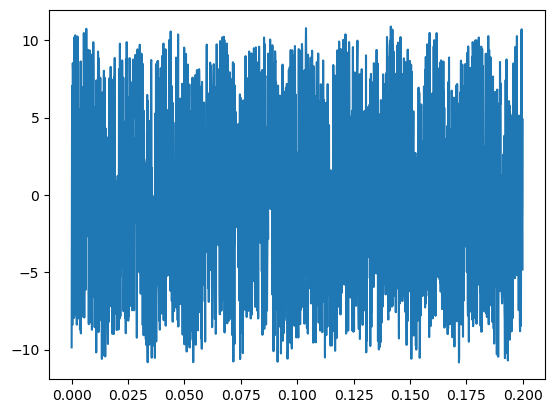

In [23]:
freq0 = 51
nFrame = 10
nShort = 1000
nPoint = nFrame * nShort
t = np.linspace(0, 1.0, nPoint, endpoint=False)
print(t[:10])
sig = np.sin(2 * np.pi * freq0 * t)
rng = np.random.default_rng()
noise = rng.uniform(low=-10.0, high=10.0, size=nPoint)
snp1 = sig + noise
plt.plot(t[:2000], snp1[:2000])

It is seriously noisy but we can still see that there might be something periodic in there. I remind you that the full-length FT does a brilliant job of finding the signal in the noise.

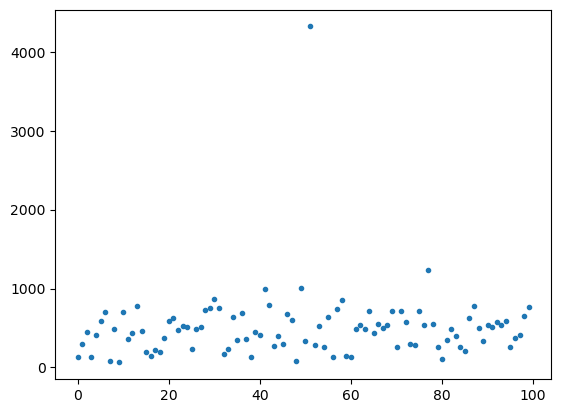

In [24]:
fftnp1 = np.fft.rfft(snp1, axis=0)
freq = np.linspace(0, 1.0/(t[2]-t[0]), int(nPoint/2) + 1)
plt.plot(freq[:100], np.absolute(fftnp1[:100]), '.')

There we see the energy in our signal channel is more than 4 times the average energy in any other channel.

Now we split this into 10 frames and window the frames before transforming.

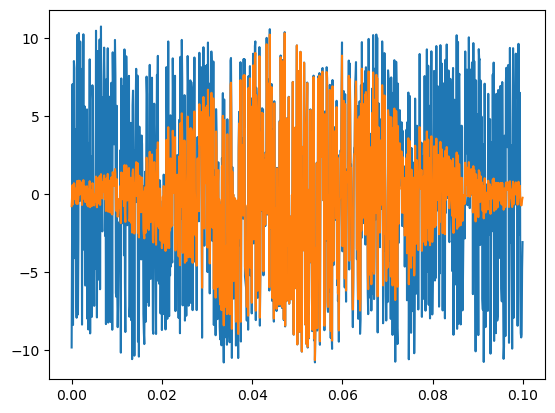

In [29]:
nframes = np.reshape(snp1, (nFrame, nShort),
                                 order='A')
plt.plot(time[:nShort], nframes[0,:])
wnframes = np.zeros_like(nframes)
hwin = np.hamming(nShort)
for i in range(nFrame):
    wnframes[i, :] = hwin * nframes[i, :]
plt.plot(time[:nPtPerSample], wnframes[0,:])

In [33]:
SFTs = np.fft.rfft(wnframes, axis=1)
sfreq = np.linspace(0, 1.0/(t[2]-t[0]), int(nShort/2)+1)

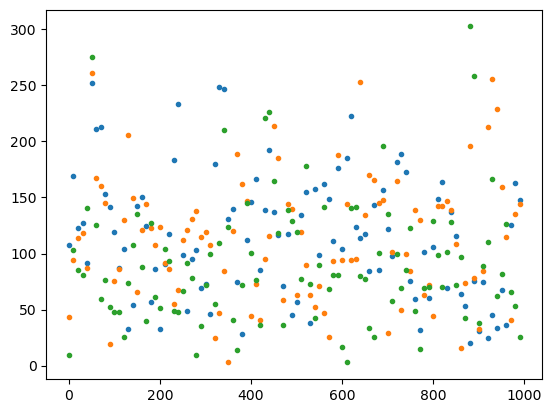

In [34]:
plt.plot(sfreq[:100], np.absolute(SFTs[0, :100]), '.')
plt.plot(sfreq[:100], np.absolute(SFTs[1, :100]), '.')
plt.plot(sfreq[:100], np.absolute(SFTs[2, :100]), '.')

And you may make of that what you will! It is true that each of the traces has a relatively high energy (>250) at the 50 Hz bin.

Now let's apply our fairly coherent reconstruction algorithm to these data. We'll do it a bit at a time to see it work. First we look at the 10 points at 50 Hz in the Argand diagram.

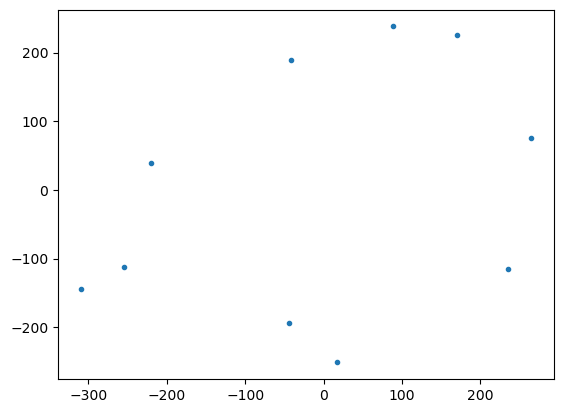

In [39]:
plt.plot(np.real(SFTs[0:10, 5]), np.imag(SFTs[0:10, 5]), '.')

Yes, well, not a very convincing circle!

Let's rotate them as best we can.

In [36]:
print(sfreq[5])


50.0


0.0 0.0 (1+0j)
0.1 31.415926535897935 (1-2.328066879653148e-15j)
0.2 62.83185307179587 (1-4.656133759306296e-15j)
0.3 94.2477796076938 (1-3.4314869601589423e-15j)
0.4 125.66370614359174 (1-9.312267518612591e-15j)
0.5 157.07963267948966 (1-9.82193361864236e-16j)
0.6 188.4955592153876 (1-6.8629739203178846e-15j)
0.7000000000000001 219.91148575128554 (1-1.2743754478771533e-14j)
0.8 251.32741228718348 (1-1.8624535037225183e-14j)
0.9 282.7433388230814 (1+3.9163938347251765e-15j)


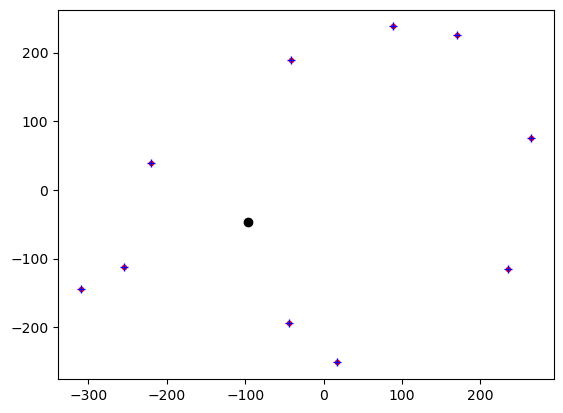

In [43]:
#w = 2 * np.pi * freq0
w = 2 * np.pi * sfreq[5]
#print(freq0, sfreq[5])
phi = np.zeros(nFrame)
ephi = np.zeros(nFrame, dtype=complex)
for i in range(nFrame):
    phi[i] = w * t[nShort * i]
    ephi[i] = np.exp(-1.0J * phi[i])
    print(t[nShort * i], phi[i], ephi[i])
rft50 = SFTs[:, 5].copy()
plt.plot(rft50.real, rft50.imag, 'r.')
for i in range(10):
    rft50[i] = SFTs[i, 5] * ephi[i]
plt.plot(rft50.real, rft50.imag, 'b+')
sum = np.sum(rft50)
plt.plot(sum.real, sum.imag, 'ko')

Ah, all our phases are multiples of $\pi$ so that the cohereing does not help. Our sum is distinctly different from zero, but not by much.

If we repeat this for the 100 Hz bin we start with this set of values

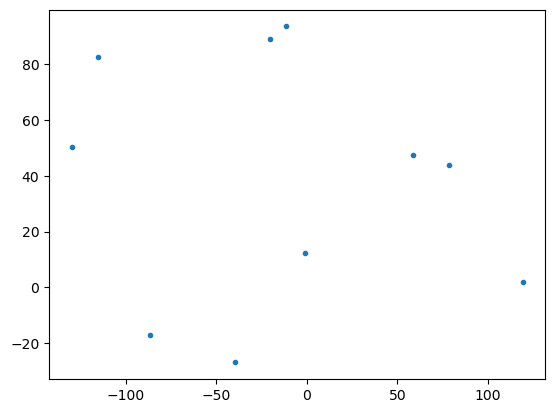

In [45]:
plt.plot(np.real(SFTs[0:10, 10]), np.imag(SFTs[0:10, 10]), '.')

Sadly not very different!

Then the rotations.

0.0 0.0 (1+0j)
0.1 62.83185307179587 (1-4.656133759306296e-15j)
0.2 125.66370614359174 (1-9.312267518612591e-15j)
0.3 188.4955592153876 (1-6.8629739203178846e-15j)
0.4 251.32741228718348 (1-1.8624535037225183e-14j)
0.5 314.1592653589793 (1-1.964386723728472e-15j)
0.6 376.9911184307752 (1-1.3725947840635769e-14j)
0.7000000000000001 439.8229715025711 (1-2.5487508957543065e-14j)
0.8 502.65482457436696 (1-3.7249070074450366e-14j)
0.9 565.4866776461628 (1+7.832787669450353e-15j)


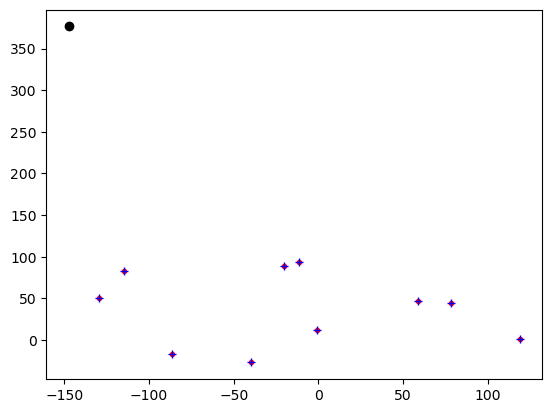

In [46]:
w10 = 2 * np.pi * sfreq[10]
#print(freq0, sfreq[5])
phi10 = np.zeros(nFrame)
ephi10 = np.zeros(nFrame, dtype=complex)
for i in range(nFrame):
    phi10[i] = w10 * t[nShort * i]
    ephi10[i] = np.exp(-1.0J * phi10[i])
    print(t[nShort * i], phi10[i], ephi10[i])
rft100 = SFTs[:, 10].copy()
plt.plot(rft100.real, rft100.imag, 'r.')
for i in range(10):
    rft100[i] = SFTs[i, 10] * ephi10[i]
plt.plot(rft100.real, rft100.imag, 'b+')
sum10 = np.sum(rft100)
plt.plot(sum10.real, sum10.imag, 'ko')

Alas, we get a LARGER sum this time than before!

I am FAR from convinced that the windowing has helped in ANY way.

What if we use the information from the template? That is, instead of using the bin starting phase correction we use the phase correction from the template.

For that, we are going to need the phases in the signal bins from the template SFTs instead of from the noise SFTs. First I have to chop up, window, and FFT the whole signal, then I redo the rotation process on the signal channel using the new phases.

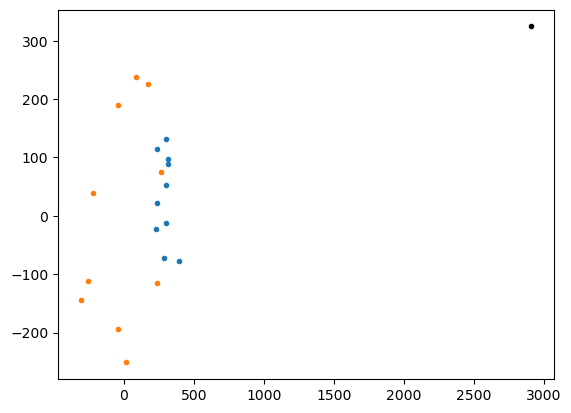

In [55]:
sframes = np.reshape(sig, (nFrame, nShort),
                                 order='A')
wsframes = np.zeros_like(sframes)
for i in range(nFrame):
    wsframes[i, :] = hwin * sframes[i, :]
wSFTs = np.fft.rfft(wsframes, axis=1)
lens = np.linalg.norm(wSFTs[5, :])
wphase = wSFTs[:, 5] / lens
newSig = SFTs[:, 5] / wphase
plt.plot(newSig.real, newSig.imag, '.')
plt.plot(SFTs[:, 5].real, SFTs[:, 5].imag, '.')
wtot = np.sum(newSig)
plt.plot(wtot.real, wtot.imag, 'k.')


and there we see the process work! All the points got rotated to roughly the same direction and so the sum was MUCH larger.

In [56]:
print(np.absolute(wtot))

2927.1927096448953


compared to the value in the 100 Hz bin

In [57]:
print(np.absolute(sum10))

404.2698831673417


So we started with a signal that was 10 times smaller than the noise and ended up with a signal/noise ratio of

In [58]:
print(np.absolute(wtot)/np.absolute(sum10))

7.240689528270465


Pretty good!